In [26]:
# import libraries
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# for graphing
import plotly.express as px

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Loan Default/loan_history.csv")
model_data = df[df.columns]

# convert to datetime for date calculations
model_data[['repaymentDate', 'loanRepaidDate', 'loanCreatedAt']] = model_data[['repaymentDate', 'loanRepaidDate', 'loanCreatedAt']].apply(pd.to_datetime)

# create column for the number of days it took to repay the loan
model_data['paybackDuration'] = model_data["loanRepaidDate"] - model_data["loanCreatedAt"]

# create col for the number of days it was overdue (negative numbers means it was paid on time)
model_data['daysOverdue'] = (model_data['repaymentDate'] - model_data["loanRepaidDate"]) * -1

# fix NaN values
model_data[['paybackDuration', 'daysOverdue']] = model_data[['paybackDuration', 'daysOverdue']].fillna(pd.Timedelta(days=0))

# convert to int64 for label condition
model_data['daysOverdue'] = (model_data['daysOverdue'].astype('int64') / 86400)

# create labels for supervised learning, >14 days overdue is a default(NOT DEFAULT: 0, DEFAULT: 1)
model_data.loc[model_data['daysOverdue'] < 1.400000e+10	, 'target'] = 0
model_data.loc[model_data['daysOverdue'] >= 1.400000e+10	, 'target'] = 1

model_data

In [158]:
# features to use in the nn
quant_features = ['customerAge', 'loanAmount', 'interestOnLoan', 'daysOverdue']
qual_features = ['maritalStatus', 'educationLevel', 'location']

# drop unused columns
model_data = model_data.drop(columns=['customerId', 'repaymentDate', 'loanRepaidDate', 'loanStatus', 'loanCreatedAt', 'paybackDuration'])
model_data.describe()


,customerAge,loanAmount,interestOnLoan,daysOverdue,target
count,3361.000000,3.361000e+03,3361.000000,3.361000e+03,3361.000000
mean,36.945254,5.486535e+05,32351.294326,8.360607e+07,0.013984
std,28.286986,8.831417e+05,51893.648019,1.533727e+10,0.117441
min,0.000000,1.000000e+04,576.670000,-3.000000e+10,0.000000
25%,31.000000,1.000000e+05,6000.000000,-2.000000e+09,0.000000
50%,36.000000,2.730000e+05,16102.500000,0.000000e+00,0.000000
75%,41.000000,6.320000e+05,36619.840000,0.000000e+00,0.000000
max,1316.000000,1.000000e+07,600000.000000,4.450000e+11,1.000000


In [159]:
# split into train, test, and validation
train, test = train_test_split(model_data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

2150 train examples
538 validation examples
673 test examples


In [160]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = model_data.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  return ds

In [162]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for our feature.
  normalizer = preprocessing.Normalization(axis=None)

  # Prepare a Dataset that only yields our feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [164]:
# create a one-hot encoding for the categoriacal features
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
  # Create a StringLookup layer which will turn strings into integer indices
  if dtype == 'string':
    index = preprocessing.StringLookup(max_tokens=max_tokens)
  else:
    index = preprocessing.IntegerLookup(max_tokens=max_tokens)

  # Prepare a Dataset that only yields our feature
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Create a Discretization for our integer indices.
  encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())

  # Apply one-hot encoding to our indices. The lambda function captures the
  # layer so we can use them, or include them in the functional model later.
  return lambda feature: encoder(index(feature))

In [166]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

all_inputs = []
encoded_features = []

# Numeric features.
for header in quant_features:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  encoded_features.append(encoded_numeric_col)

# Categorical features encoded as string.
for header in qual_features:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=4)
  encoded_categorical_col = encoding_layer(categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [167]:
# create the neural network
all_features = tf.keras.layers.concatenate(encoded_features)
input_layer = tf.keras.layers.Dense(32, activation="relu")(all_features)
dropout = tf.keras.layers.Dropout(0.5)(input_layer)
output = tf.keras.layers.Dense(1)(dropout)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

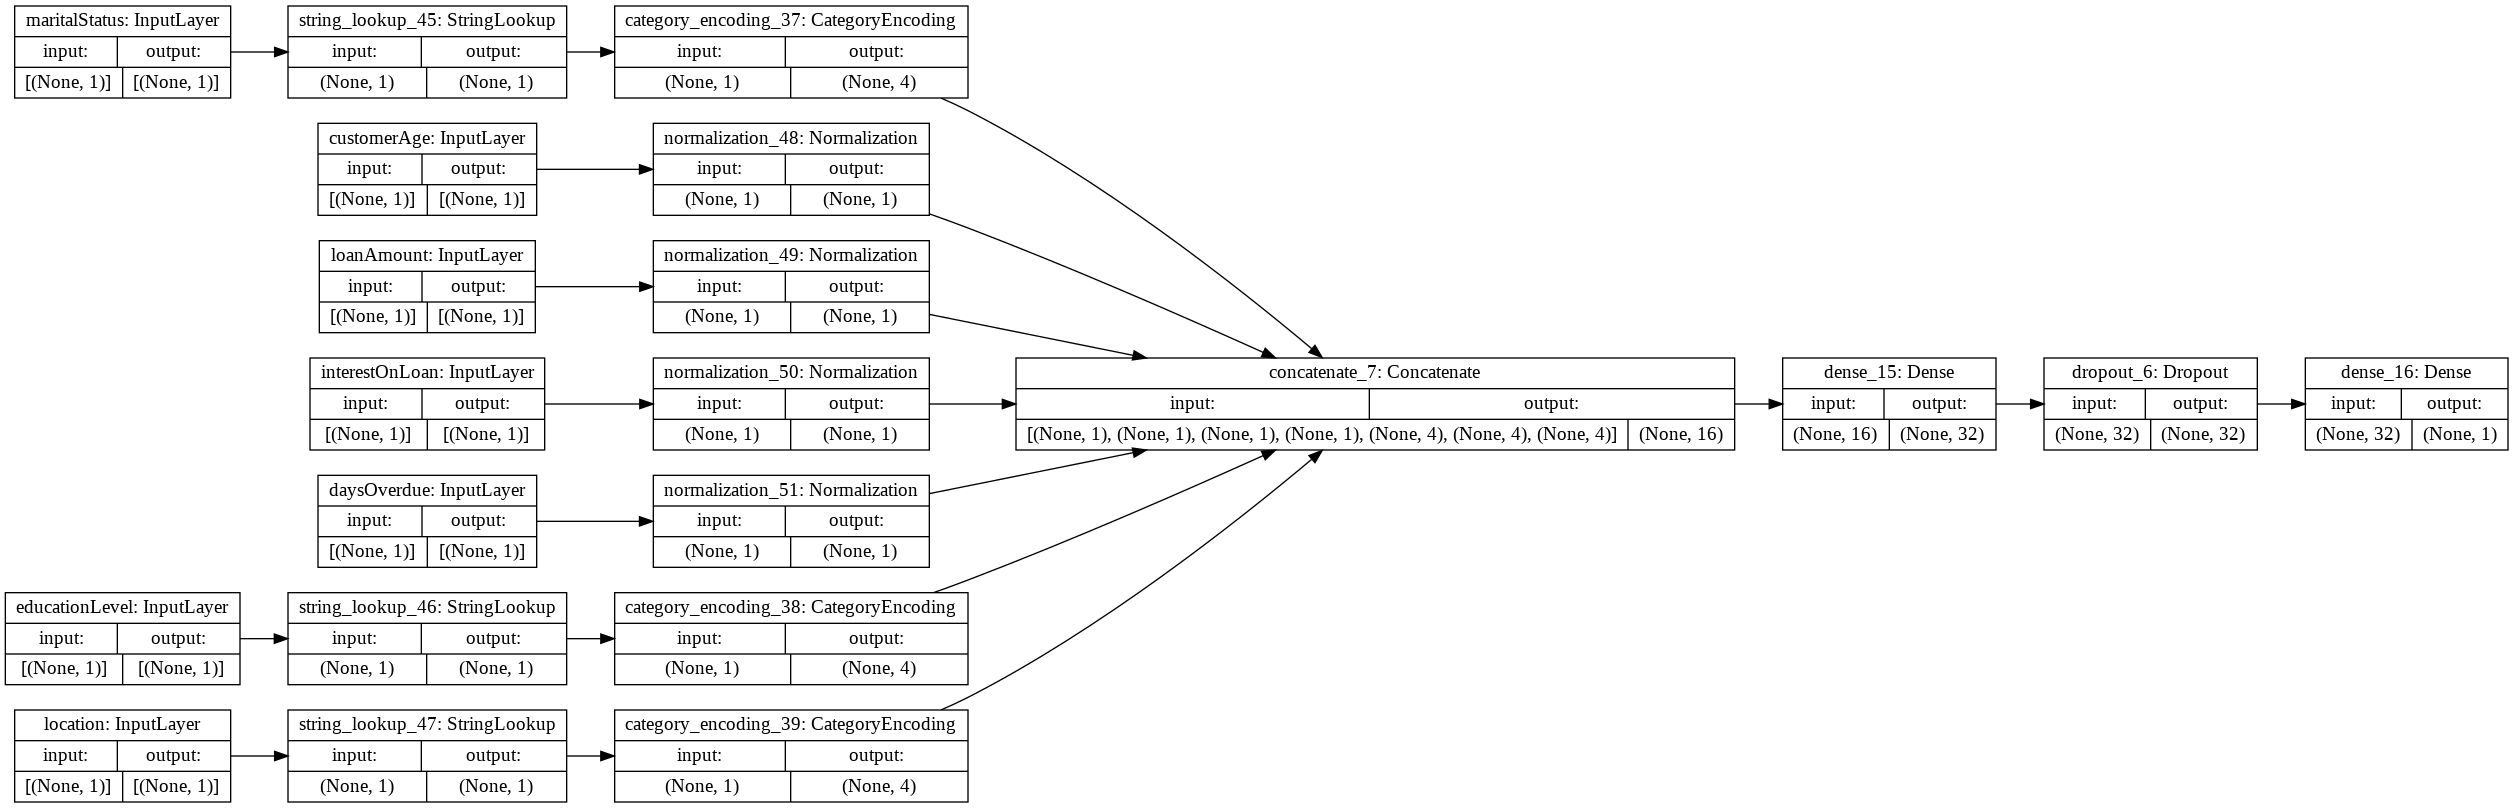

In [168]:
# rankdir='LR' is used to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [ ]:
model.fit(train_ds, epochs=10, validation_data=val_ds)

In [170]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)
print("Loss", loss)

14/14 [==============================] - 0s 2ms/step - loss: 0.0895 - accuracy: 0.9860
Accuracy 0.9860160946846008
Loss 0.08952359110116959


## Distribution Analysis

In [ ]:
for col in model_data.columns:
  fig = px.histogram(model_data, x=str(col))
  fig.show()

'''
NOTES
- Age is weird(two ids are over 900 years)
- Some loan amounts are massive
- lots of OTHER for marriage, which isnt helpful
- some payments marked as paid, but they were overdue
- labeled as repaid even if it was overdue for > 14 days(where do we consider it defaulted)
'''